<a href="https://colab.research.google.com/github/shashwat123u/EMOTION_DETECTION/blob/main/EMOTION_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import files
import zipfile
import os
# Upload ZIP file manually
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [3]:
# Get the uploaded file name from the uploaded dictionary
zip_file_name = list(uploaded.keys())[0] # Assuming only one file was uploaded
extract_path = '/content/emotion_dataset'
# Extract
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
# Check folders
print("Extracted folders:", os.listdir(extract_path))

Extracted folders: ['CK+48', 'ck']


In [4]:
data_dir = extract_path + '/CK+48'  # extracted path
categories = sorted(os.listdir(data_dir))  # e.g., anger, happy, etc.
img_size = 48

data = []
labels = []

# Loop through each category
for idx, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        data.append(img)
        labels.append(idx)

# Convert to arrays and normalize
X = np.array(data).reshape(-1, img_size, img_size, 1).astype('float32') / 255.0
y = to_categorical(labels, num_classes=len(categories))


In [5]:
# test and train data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, Input

model = Sequential()
model.add(Input(shape=(64, 64, 3)))  # Correct input definition
model.add(Conv2D(32, (3, 3), activation='relu'))

In [8]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Input(shape=(48, 48, 1)),  # <- Recommended way
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(7, activation='softmax')  # assuming 7 emotions
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Callbacks
callbacks = [
    EarlyStopping(patience=30, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint("final_emotion_model.keras", save_best_only=True)
]
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 445ms/step - accuracy: 0.2670 - loss: 4.2054 - val_accuracy: 0.1777 - val_loss: 5.0879
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.4199 - loss: 1.6545 - val_accuracy: 0.1777 - val_loss: 10.7268
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.5738 - loss: 1.1888 - val_accuracy: 0.1777 - val_loss: 10.4088
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 378ms/step - accuracy: 0.6131 - loss: 1.0843 - val_accuracy: 0.1726 - val_loss: 9.9494
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - accuracy: 0.6687 - loss: 0.9242 - val_accuracy: 0.1624 - val_loss: 7.8992
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.7098 - loss: 0.8188 - val_accuracy: 0.0558 - val_loss: 8.6352
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - accuracy: 0.7471 - loss: 0.6946 - val_accuracy: 0.0609 - val_loss: 6.7834
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - accuracy: 0.7396 - loss: 0.6637 - val_accuracy: 0.0

In [10]:
# prediction
def predict_emotion(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img.reshape(1, img_size, img_size, 1).astype('float32') / 255.0
    prediction = model.predict(img)
    return categories[np.argmax(prediction)]

# Example
# print(predict_emotion("/mnt/data/emotion_dataset/CK+48/happy/example.png"))

In [11]:
 # Step 8: Evaluation
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9788 - loss: 0.0624
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9765 - loss: 0.0614
Train Accuracy: 97.58%
Test Accuracy: 97.46%


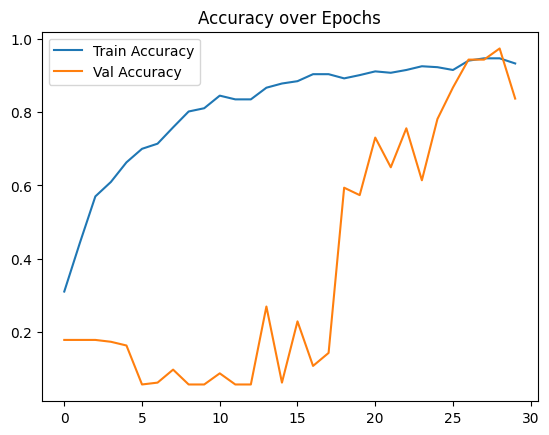

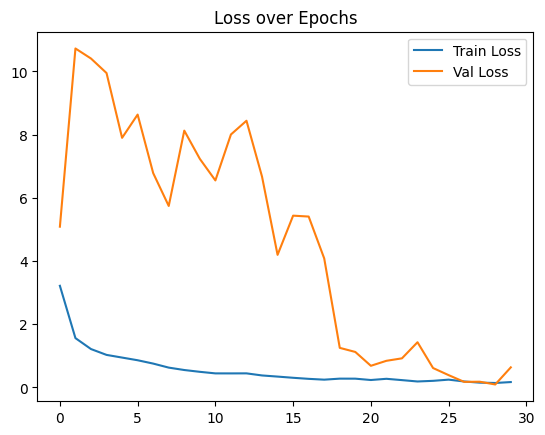

In [12]:
# Plotting of accuracy and Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Classification Report:

              precision    recall  f1-score   support

       anger       0.96      0.96      0.96        27
    contempt       0.83      0.91      0.87        11
     disgust       1.00      1.00      1.00        35
        fear       1.00      1.00      1.00        15
       happy       1.00      1.00      1.00        42
     sadness       0.89      0.94      0.91        17
    surprise       1.00      0.96      0.98        50

    accuracy                           0.97       197
   macro avg       0.96      0.97      0.96       197
weighted avg       0.98      0.97      0.98       197



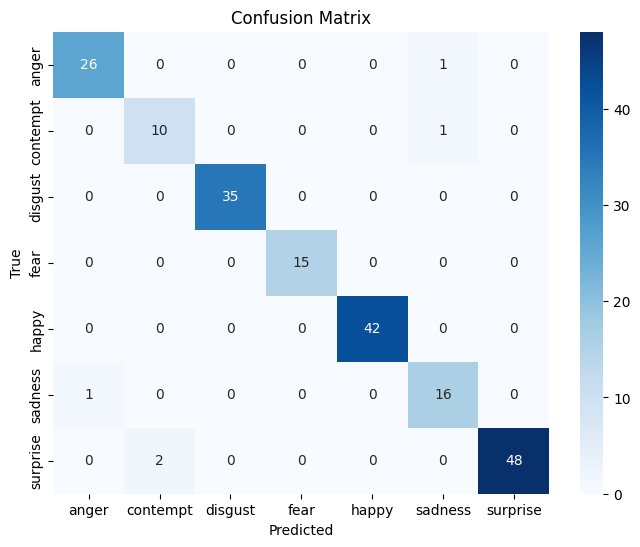

In [13]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on X_test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=categories))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
model.save("final_emotion_model_final.keras") #  # Save Model

Saving S062_002_00000014.png to S062_002_00000014.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


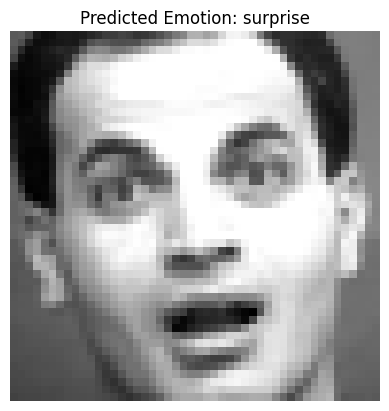

S062_002_00000014.png → Predicted Emotion: surprise


In [23]:
from google.colab import files
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os # Add this import statement
# Upload image
uploaded = files.upload()
# Categories must match your model output
categories = sorted(os.listdir("/content/emotion_dataset/CK+48"))
# Prediction function
def predict_emotion_and_show(image_path, model):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (48, 48))
    img_input = img_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(img_input)
    predicted_label = categories[np.argmax(prediction)]
   # Show the image with predicted label
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted Emotion: {predicted_label}")
    plt.axis('off')
    plt.show()
    return predicted_label
# Predict for each uploaded image
# Ensure the 'model' variable is defined from previous cells
for file_name in uploaded.keys():
    emotion = predict_emotion_and_show(file_name, model)
    print(f"{file_name} → Predicted Emotion: {emotion}")

In [24]:
# Step 1: Install Gradio
!pip install -q gradio

# Step 2: Import required libraries
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
# Step 3: Load your trained model (.keras file should be in same folder)
model = load_model('final_emotion_model.keras')
# Step 4: Define your emotion categories (7-class)
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
# Step 5: Preprocessing + Prediction function
def predict_emotion(image):
    image = image.convert('L').resize((48, 48))  # Convert to grayscale
    img_array = np.array(image).reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(img_array)
    predicted_emotion = categories[np.argmax(prediction)]
    return f"😃 Predicted Emotion: {predicted_emotion.upper()}"
# Step 6: Launch Gradio app with public URL
gr.Interface(
    fn=predict_emotion,
    inputs=gr.Image(type="pil", label="Upload Face Image"),
    outputs=gr.Textbox(label="Emotion"),
    title="Emotion Detection from Image",
    description="Upload a face image (grayscale or colored), and the model will predict the emotion."
).launch(share=True, inbrowser=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://acd8fcd966e473da21.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
